In [2]:
import numpy as np
import pandas as pd
import random

import gc
import math
import os.path
import time

import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings("ignore")


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data_path='/content/drive/MyDrive/Colab Notebooks/Bitcoin_Trading/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [10]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [11]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [12]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



In [13]:
idxx=1121

x_series=train_x_array[idxx,:,1]
y_series = train_y_array[idxx,:,1]
print(x_series.shape)
print(y_series.shape)

(1380,)
(120,)


In [14]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # df convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]
    
    return [x_train, y_train]

In [15]:
x_series=pd.DataFrame(x_series.reshape((-1,1)))
lookback=20
x_train, y_train = split_data(x_series, lookback)

In [16]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)

x_train.shape =  (1360, 19, 1)
y_train.shape =  (1360, 1)


In [17]:
import torch
import torch.nn as nn
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(x_train).type(torch.Tensor) #(batch_size, time_seq,n_feature)=(1361,19,1)
y_train_lstm1= torch.from_numpy(y_train).type(torch.Tensor) #(batch_size, time_seq,n_feature)=(1361,1)
y_train_lstm2=torch.from_numpy(y_series.reshape([-1,1])).type(torch.Tensor) ##(batch_size, time_seq,n_feature)=(120,1)
y_train_lstm=torch.cat([y_train_lstm1, y_train_lstm2], dim=0) ##(batch_size, time_seq,n_feature)=(1481,1)

In [18]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [29]:
## 수정본
class LSTM(nn.Module):
  def __init__(
      self,
      input_dim,
      hidden_dim,
      num_layers,
      output_dim):
    
    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.num_layers=num_layers
    self.output_dim=output_dim

    super().__init__()

    self.lstm=nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True) 
    self.fc = nn.Linear(hidden_dim*2, output_dim)
    self.outputs=[]
  
  def forward(self, x, data_raw, lookback): #x =x_train, data_raw=x_series, lookback=주기
    outputs=[]
    for i, input_t in enumerate(x.chunk(x.size(0), dim=0)):
      # |x|=(batch_size, time_step, vec_size)
      x,_=self.lstm(input_t)

      #|x|=(batch_size, time_step, hidden_size*2)
      y= self.fc(x[:,-1])

      #|y|=(batch_size, value)
      outputs.append(np.squeeze(y.detach().numpy(), axis=0)) #outputs : [[1], [2], ...] 형태
      


    #예측값을 입력값으로 넣을 빈 공간을 만들기
    future=120
    train_future=np.zeros((future, 19,1)) #train_future = (120,19,1)
    data_raw = data_raw.to_numpy() # df convert to numpy array

    #예측값을 입력값으로 넣어주기
    for index in range(len(data_raw)-lookback+1,len(data_raw)+future-lookback+1): #range(1361, 1481)
      if index<len(data_raw):
        idx=(index-(len(data_raw)-lookback+1))
        if idx==0:
          train_future[idx]=data_raw[index:len(data_raw)]

          train_ft=torch.from_numpy(train_future[idx]).type(torch.Tensor)
          train_ft=train_ft.view([-1,lookback-1,1])

          # |x|=(batch_size, time_step, vec_size)
          train_ft, _=self.lstm(train_ft)

          #|x|=(batch_size, time_step, hidden_size*2)
          y= self.fc(train_ft[:,-1])

          #|y|=(batch_size, value)
          outputs.append(np.squeeze(y.detach().numpy(), axis=0))  #outputs : [[1], [2], ...] 형태
          


        #len(data_raw)=1380, 1362~1380 넣고 1381 예측으로 해야함
        else:
          train_future[idx]=np.concatenate((data_raw[index:len(data_raw)],np.array(outputs[-(idx):])),axis=0)


          train_ft=torch.from_numpy(train_future[idx]).type(torch.Tensor)
          train_ft=train_ft.view([-1,lookback-1,1])

          # |x|=(batch_size, time_step, vec_size)
          train_ft, _=self.lstm(train_ft)

          #|x|=(batch_size, time_step, hidden_size*2)
          y= self.fc(train_ft[:,-1])

          #|y|=(batch_size, value)
          outputs.append(np.squeeze(y.detach().numpy(), axis=0))  #outputs : [[1], [2], ...] 형태

      else:
        idx=(index-(len(data_raw)-lookback+1))
        train_future[idx]=outputs[-(lookback-1):] #train_future[idx] : (19,1)

        train_ft=torch.from_numpy(train_future[idx]).type(torch.Tensor)
        train_ft=train_ft.view([-1,lookback-1,1])

        # |x|=(batch_size, time_step, vec_size)
        train_ft, _=self.lstm(train_ft)

        #|x|=(batch_size, time_step, hidden_size*2)
        y= self.fc(train_ft[:,-1])

        #|y|=(batch_size, value)
        outputs.append(np.squeeze(y.detach().numpy(), axis=0))  #outputs : [[1], [2], ...] 형태
    
    outputs = torch.as_tensor(outputs) #list형태를 torch 형태로 바꿔주기
    #{outputs]=(batch_size, value)
    self.outputs=outputs

    return outputs 

In [49]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [51]:
import time

start_time = time.time()
lstm = []

y_train_pred = model(x=x_train, data_raw=x_series, lookback=20) #계속해서 model(x_train), 하고 예측값 넣어주고 이 짓을 반복해야하나.?그러면 이후에 criteerion에서 업데이트할 때 안 걸림돌이 안 되나?

loss = criterion(y_train_pred, y_train_lstm)
print("MSE: ", loss.item())

optimizer.zero_grad()
loss.backward()
optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

MSE:  0.8027034401893616


RuntimeError: ignored

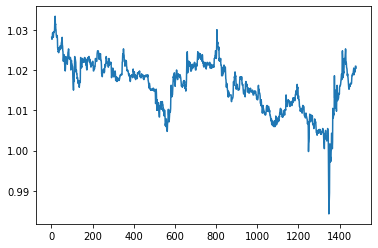

In [47]:
from matplotlib import pyplot as plt

x_values=range(1,1481)
y_values2=np.squeeze(y_train_lstm.tolist(), axis=1)
plt.plot(x_values, y_values2)
plt.show()

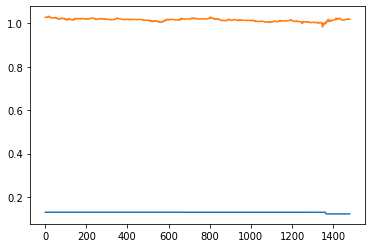

In [48]:
a=model.outputs
x_values=range(1,1481)
y_values=np.squeeze(a.tolist(), axis=1)
y_values2=np.squeeze(y_train_lstm.tolist(), axis=1)

plt.plot(x_values, y_values)
plt.plot(x_values, y_values2)
plt.show()